# Figs of Horizontal Turner Angles
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Global annual-mean](#first-bullet)
* [Basin-wide annual-mean](#second-bullet)
* [Global timeseries?](#third-bullet)

> Note: the time dimension is only for first 6 months of CESM data

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import pop_tools
import gcsfs

In [3]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ta_clim = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/ta_clim.zarr'))
ta = ta_clim.ta_clim

In [4]:
#making it go to -90,90
ta = ta/2

In [5]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.a3c1915fe86d4cb8b746347985a1e723/status,


In [ ]:
client.close()
cluster.close()

# 1) Global annual-mean <a class='anchor' id='first-bullet'> </a>

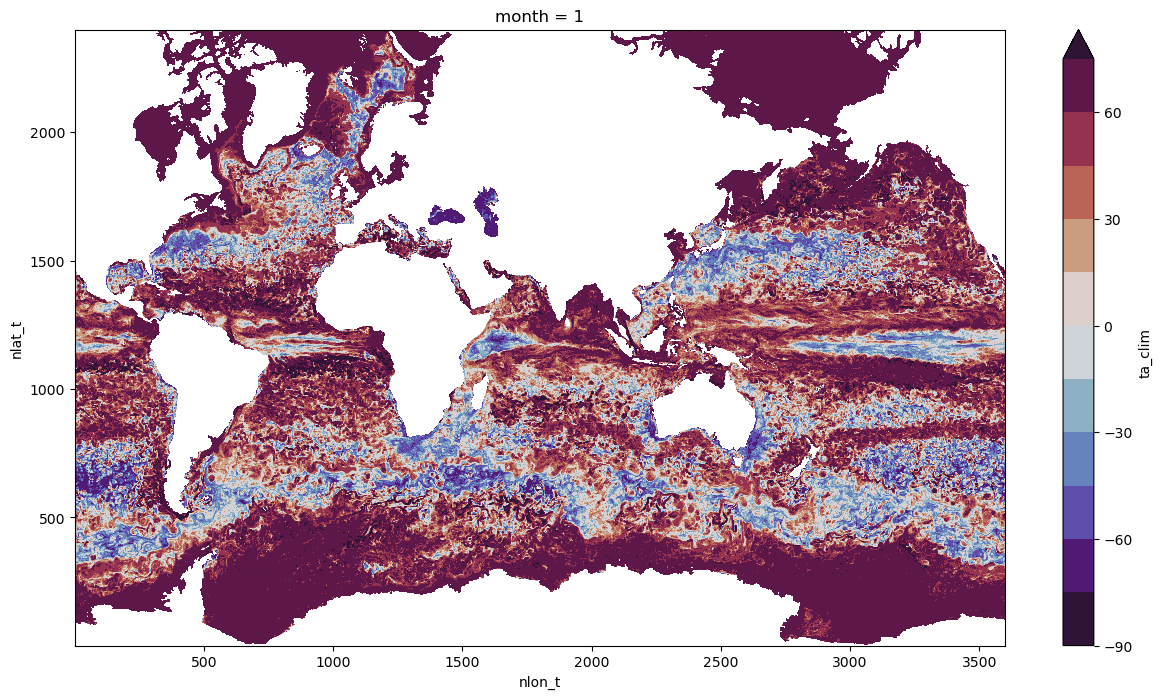

In [7]:
#global turner angle
fig, ax = plt.subplots(figsize=(15,8))
ta.isel(month=0).plot.contourf(levels=np.arange(-90, 90, 15), cmap='twilight_shifted');

In [12]:
ta.nlon_t

<xarray.DataArray 'nlon_t' (nlon_t: 3600)>
array([5.0000e-01, 1.5000e+00, 2.5000e+00, ..., 3.5975e+03, 3.5985e+03,
       3.5995e+03])
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
Attributes:
    axis:     X

In [8]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas

In [11]:
proj = ccrs.Robinson() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

#ax.set_extent([0, 360, -90, 90], crs=ccrs.PlateCarree())
ax.set_global()
#ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

#ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
#                                        edgecolor='face',
#                                        facecolor='0.5'))
#ta.isel(month=0).plot.contourf(levels=np.arange(-90, 90, 15), cmap='twilight', ax=ax, transform=ccrs.PlateCarree());

#cb = fig.colorbar(im, ax=ax, shrink=0.4)
#cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

plt.contourf(ta.nlon_t, 
             ta.nlat_t,  
             ta.isel(month=0),
             transform=ccrs.PlateCarree())

#g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
#g1.xlabels_top = False
#g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

#plt.title("Difference between \n SODA (1997-2019) and WOA (1981-2010)", fontsize=26)
#plt.savefig('bot-temp-sodaWoa8110-1kmisobath.pdf');

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd2948b9ca0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd2948b9af0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_global()
plt.contourf(ta.nlon_t, 
             ta.nlat_t,  
             ta.isel(month=0),
             transform=ccrs.PlateCarree())

# 2) Basin-wide annual-mean <a class='anchor' id='second-bullet'> </a>